<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert-len64batch32_merge_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers --quiet
!pip install wget --quiet

In [2]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [3]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
import torch.nn.functional as F



class BertClassifier:

    def __init__(self, path, n_classes=2,max_len=64):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = max_len
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer,max_len=64)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=32, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x)[0] for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x)[0] for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test,digits=4))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            plot_cm(y_test,predictions_test)
            predictions_test = [self.predict(x)[1] for x in X_test]
            plot_roc(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        with torch.no_grad():
          outputs = self.model(
              input_ids=input_ids.unsqueeze(0),
              attention_mask=attention_mask.unsqueeze(0)
          )
        # ii=1
        # if ii==1:
        #   print('outputs')
        #   print(outputs)
        #   print()
        #   print('outputs.logits')
        #   print(outputs.logits)
        #   print()
        #   print('torch.argmax(outputs.logits, dim=1).cpu().numpy()')
        #   print(torch.argmax(outputs.logits, dim=1).cpu().numpy())
        #   print()
        #   print('torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]')
        #   print(torch.argmax(outputs.logits, dim=1).cpu().numpy()[0])
        #   ii=100
        #   print('F.softmax(outputs.logits, dim=1).cpu().numpy()')
        #   print(F.softmax(outputs.logits, dim=1).cpu().numpy())
        #   print()
        #   print('label=1,F.softmax(outputs.logits, dim=1).cpu().numpy()[0][1]')
        #   print(F.softmax(outputs.logits, dim=1).cpu().numpy()[0][1])
        #   print()
        #   print('F.sigmoid(outputs.logits).cpu().numpy()')
        #   print(F.sigmoid(outputs.logits).cpu().numpy())
        #   print()
        #   print('np.max(F.softmax(outputs.logits, dim=1).cpu().numpy()[0])')
        #   print(np.max(F.softmax(outputs.logits, dim=1).cpu().numpy()[0]))
        #   # raise ValueError("Real error")
        #   print('prediction')

          propability_label_1=F.softmax(outputs.logits, dim=1).cpu().numpy()[0][1]
          prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction,propability_label_1

In [5]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

def plot_roc(y_test,predictions_test):
#   print('рассчитываем ROC AUC')
#   print(predictions_test)
#   print("y_test")
#   print(y_test)
  # рассчитываем ROC AUC
  lr_auc = roc_auc_score(y_test, predictions_test)
  print(': ROC AUC=%.3f' % (lr_auc))
  # рассчитываем roc-кривую
  fpr, tpr, treshold = roc_curve(y_test, predictions_test)
  roc_auc = auc(fpr, tpr)
  # строим график

  # размеры шрифта
  SMALL_SIZE = 10
  MEDIUM_SIZE = 14
  BIGGER_SIZE = 16

  plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
  plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
  plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
  plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
  plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
  plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
  plt.plot(fpr, tpr, color='darkorange',
          label='ROC кривая (area = %0.3f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC-кривая')
  plt.legend(loc="lower right",)
  plt.show()
  print('рассчитываем ROC AUC')

In [6]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Матрица ошибок')
  plt.ylabel('Актуальное значение')
  plt.xlabel('Прогнозируемое значение')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])
  plt.show()

In [7]:
import wget
import os

PATH_CLEANED_DATASET='data_original_RU_merge_2ch_and_ok.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET


if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [8]:
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values
print(len(sentences))
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)   # .15  .2
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=.5, random_state=42) # .1764705882352941   .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

262702
(210161,)
(26270,)
(26271,)


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

**********
Model: cointegrated/rubert-tiny
Epoch 1/5


100%|██████████| 6568/6568 [03:52<00:00, 28.23it/s]


Train loss 0.19401716138136968 accuracy 0.9256141719919491
Valid:
Accuracy: 95.6 %
Recall: 84.07 %
precision: 0.9416960946583235, recall: 0.9118002020904994, f1score: 0.9258116542441652
Test:
Accuracy: 95.79 %
Recall: 84.94 %
precision: 0.945318183115495, recall: 0.9166060095463713, f1score: 0.9300942231478148
*********************
              precision    recall  f1-score   support

           0     0.9648    0.9838    0.9742     21216
           1     0.9258    0.8494    0.8860      5054

    accuracy                         0.9579     26270
   macro avg     0.9453    0.9166    0.9301     26270
weighted avg     0.9573    0.9579    0.9572     26270

Accuracy: 95.79 %
Recall: 84.94 %
Precision: 92.58 %
F1-score: 88.6 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  20872
False Positives:  344
False Negatives:  761
True Positives:  4293


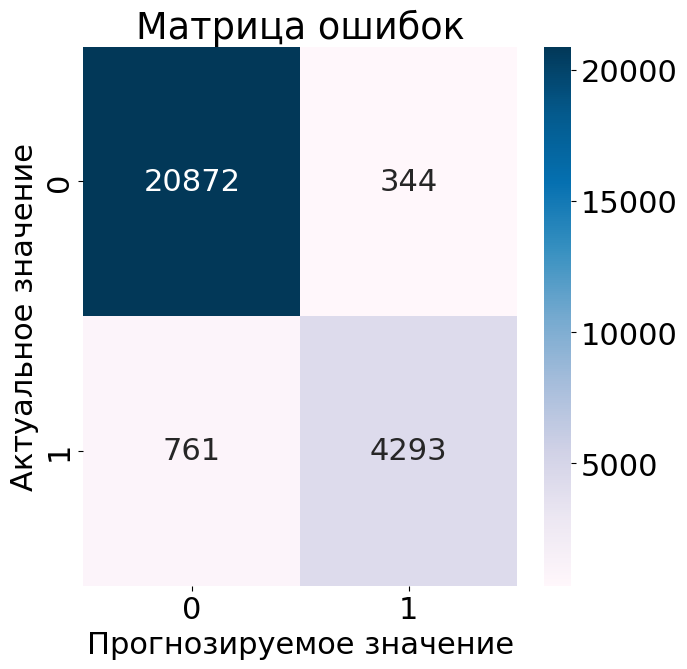

рассчитываем ROC AUC
[0.018465618, 0.0010040756, 0.0012669854, 0.97557974, 0.0021394608, 0.01946364, 0.04700598, 0.021849766, 0.00096189545, 0.006261657, 0.0006675564, 0.0012045205, 0.003897169, 0.014947494, 0.03535937, 0.0019068659, 0.9798645, 0.0013413548, 0.0009312269, 0.0011311239, 0.0055554966, 0.0054534655, 0.0033715134, 0.023538172, 0.014828445, 0.0018917198, 0.0010491498, 0.008688857, 0.010492052, 0.0008272495, 0.01745892, 0.0037817908, 0.002597347, 0.9879872, 0.0011312562, 0.0044913176, 0.0011022504, 0.05641836, 0.006794744, 0.0056718145, 0.026538875, 0.0035374088, 0.0064868312, 0.0023301335, 0.9549132, 0.004944487, 0.0018933016, 0.15830186, 0.020161157, 0.028588906, 0.004329304, 0.009423614, 0.004261394, 0.005823199, 0.007799916, 0.013893708, 0.0034334557, 0.007887969, 0.08396454, 0.0026411593, 0.61558795, 0.0018052256, 0.0018729942, 0.0021679518, 0.009723263, 0.007864233, 0.0034325256, 0.003749193, 0.8156224, 0.004425449, 0.1819822, 0.032693665, 0.008823052, 0.065426685, 0.0

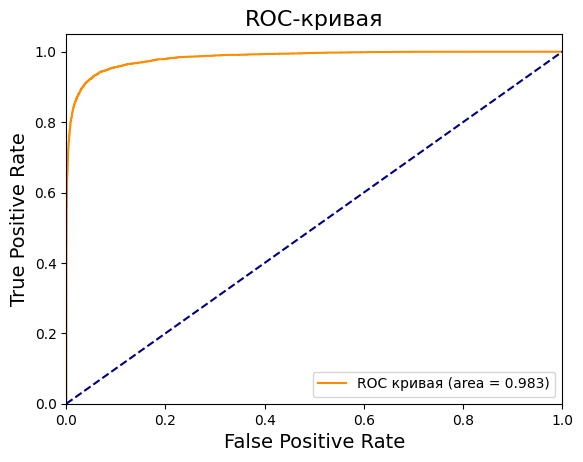

рассчитываем ROC AUC
Epoch 2/5


100%|██████████| 6568/6568 [03:56<00:00, 27.78it/s]


Train loss 0.11664924704009326 accuracy 0.9596452243755978
Valid:
Accuracy: 95.87 %
Recall: 88.98 %
precision: 0.9328910173069812, recall: 0.9322888493177957, f1score: 0.9325895451096108
Test:
Accuracy: 96.21 %
Recall: 90.66 %
precision: 0.9376252257980473, recall: 0.9409787100968663, f1score: 0.939289893696293
*********************
              precision    recall  f1-score   support

           0     0.9777    0.9753    0.9765     21216
           1     0.8976    0.9066    0.9021      5054

    accuracy                         0.9621     26270
   macro avg     0.9376    0.9410    0.9393     26270
weighted avg     0.9623    0.9621    0.9622     26270

Accuracy: 96.21 %
Recall: 90.66 %
Precision: 89.76 %
F1-score: 90.21 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  20693
False Positives:  523
False Negatives:  472
True Positives:  4582


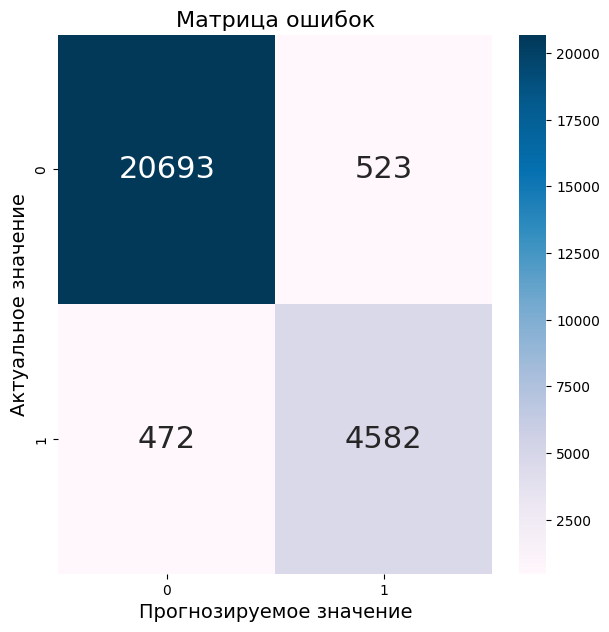

рассчитываем ROC AUC
[0.014300406, 0.000885259, 0.001008455, 0.976263, 0.0025288225, 0.017920366, 0.023433767, 0.024571361, 0.00081480795, 0.00895088, 0.0004273908, 0.00069739314, 0.008434721, 0.009810117, 0.09377797, 0.0016162113, 0.9860196, 0.0008168899, 0.0006241017, 0.00065133773, 0.0040511205, 0.0057080556, 0.0019932152, 0.05607095, 0.005733263, 0.0010269182, 0.0010989435, 0.007752338, 0.022256397, 0.00067444536, 0.041940235, 0.0023187108, 0.002377592, 0.99086326, 0.0007738284, 0.003071402, 0.00061997684, 0.039698455, 0.0024009964, 0.0044784476, 0.07934124, 0.0020630073, 0.03546373, 0.0016465945, 0.9962723, 0.0043104785, 0.001119813, 0.091609694, 0.022178344, 0.011891725, 0.0023222198, 0.018348673, 0.0024326942, 0.003474583, 0.0075618443, 0.019327128, 0.003618017, 0.0028230664, 0.07037276, 0.0022251075, 0.86589044, 0.0025082403, 0.004068144, 0.0027632404, 0.005342982, 0.0028767367, 0.007524812, 0.0038914315, 0.9030657, 0.0033227848, 0.13821016, 0.03821302, 0.005046843, 0.07014928,

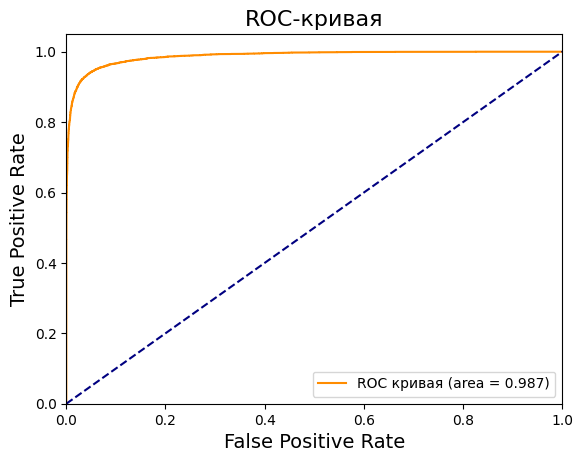

рассчитываем ROC AUC
Epoch 3/5


100%|██████████| 6568/6568 [04:00<00:00, 27.26it/s]


Train loss 0.0994549882332352 accuracy 0.9662925090763749
Valid:
Accuracy: 96.08 %
Recall: 90.72 %
precision: 0.9331331547541898, recall: 0.9402454466537518, f1score: 0.9366352049469662
Test:
Accuracy: 96.35 %
Recall: 92.3 %
precision: 0.9362267104668762, recall: 0.9480588061455137, f1score: 0.9419918229337383
*********************
              precision    recall  f1-score   support

           0     0.9815    0.9731    0.9773     21216
           1     0.8909    0.9230    0.9067      5054

    accuracy                         0.9635     26270
   macro avg     0.9362    0.9481    0.9420     26270
weighted avg     0.9641    0.9635    0.9637     26270

Accuracy: 96.35 %
Recall: 92.3 %
Precision: 89.09 %
F1-score: 90.67 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  20645
False Positives:  571
False Negatives:  389
True Positives:  4665


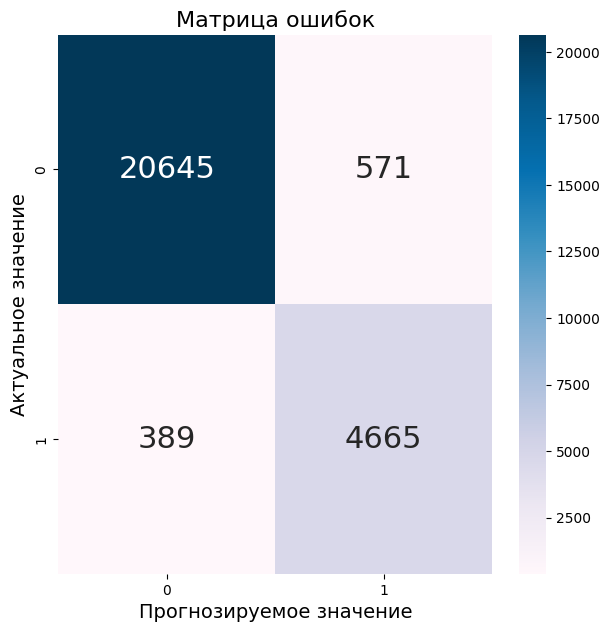

рассчитываем ROC AUC
[0.0065482454, 0.00052054157, 0.00060767063, 0.9903598, 0.0015628947, 0.036103595, 0.03141307, 0.011145906, 0.00047978494, 0.010611151, 0.0002666192, 0.0004141059, 0.009005842, 0.0039355583, 0.11326959, 0.0014023215, 0.99678963, 0.00040017522, 0.00037764927, 0.00035809493, 0.0033559483, 0.0022015485, 0.0012410348, 0.019884193, 0.003647158, 0.00064958027, 0.0005252218, 0.0059343423, 0.018481141, 0.00051996316, 0.01680256, 0.0011024881, 0.0008695783, 0.9947292, 0.00038796716, 0.00097176497, 0.0003550358, 0.014860668, 0.0038578496, 0.0027372309, 0.20370002, 0.002940393, 0.04006956, 0.0010923487, 0.99911994, 0.002504781, 0.000756386, 0.043225802, 0.008063631, 0.0070951614, 0.004456454, 0.0077313483, 0.001590249, 0.002049219, 0.0040813796, 0.014589419, 0.0010829855, 0.004222536, 0.006482717, 0.0011754037, 0.9739014, 0.0010823868, 0.0020980479, 0.0016398324, 0.005335241, 0.0038691298, 0.005360277, 0.0017835406, 0.7668173, 0.0030633514, 0.10458708, 0.045078937, 0.00362353

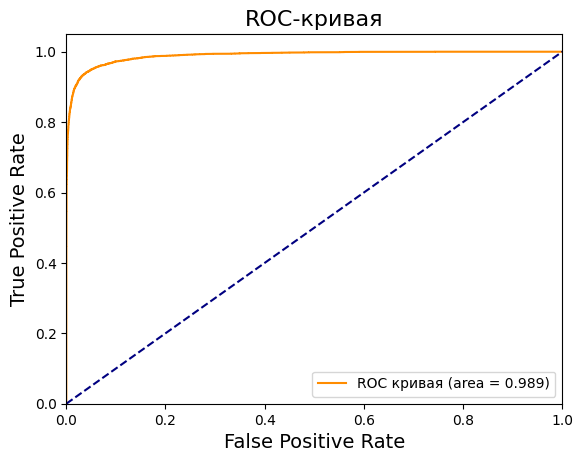

рассчитываем ROC AUC
Epoch 4/5


100%|██████████| 6568/6568 [04:07<00:00, 26.50it/s]


Train loss 0.0884892381373203 accuracy 0.9705987314487465
Valid:
Accuracy: 96.31 %
Recall: 90.57 %
precision: 0.9387895819103648, recall: 0.9410893715881631, f1score: 0.9399339100398808
Test:
Accuracy: 96.52 %
Recall: 92.13 %
precision: 0.9406838356149921, recall: 0.9484646138446855, f1score: 0.9445097861636094
*********************
              precision    recall  f1-score   support

           0     0.9811    0.9757    0.9784     21216
           1     0.9002    0.9213    0.9106      5054

    accuracy                         0.9652     26270
   macro avg     0.9407    0.9485    0.9445     26270
weighted avg     0.9656    0.9652    0.9654     26270

Accuracy: 96.52 %
Recall: 92.13 %
Precision: 90.02 %
F1-score: 91.06 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  20700
False Positives:  516
False Negatives:  398
True Positives:  4656


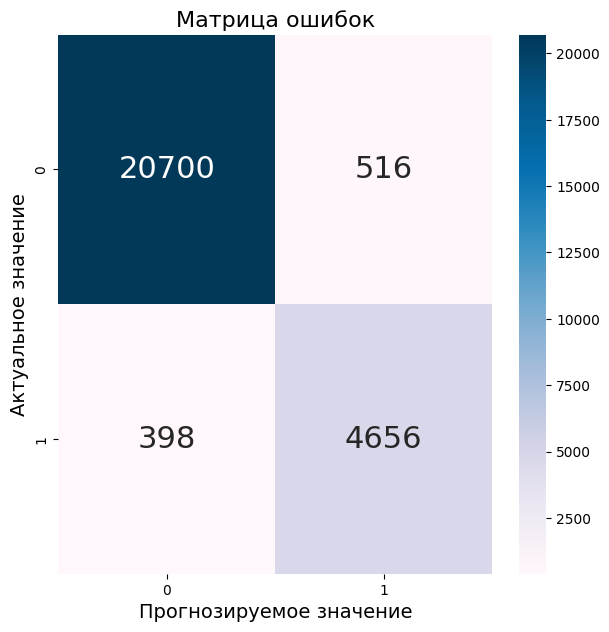

рассчитываем ROC AUC
[0.007539772, 0.00040840133, 0.00049024133, 0.99152476, 0.0012106652, 0.019506188, 0.020075925, 0.008528116, 0.00039889166, 0.0071159825, 0.00023626306, 0.00030790537, 0.0055661835, 0.002917113, 0.0750151, 0.0013184801, 0.9983706, 0.00031242604, 0.00034414578, 0.0003146455, 0.0033203159, 0.001476178, 0.0013497536, 0.004745917, 0.003218269, 0.00061571185, 0.0004068943, 0.005767919, 0.014405315, 0.0005102589, 0.006340261, 0.0010021367, 0.00065114227, 0.9955389, 0.00037214282, 0.00079998304, 0.00030356555, 0.007840735, 0.0023952539, 0.0022267725, 0.09005152, 0.0020089601, 0.045298416, 0.00080708513, 0.9993814, 0.0019641416, 0.0006715923, 0.019390257, 0.0029873573, 0.0033015877, 0.0017665378, 0.0044739624, 0.0014210261, 0.0022884312, 0.0038753175, 0.013746088, 0.00078404084, 0.001960701, 0.017711354, 0.00059608504, 0.98530316, 0.0007681608, 0.001869832, 0.001233429, 0.0023563628, 0.0023798645, 0.0048086317, 0.001301491, 0.64232385, 0.0021417039, 0.101121925, 0.02692936

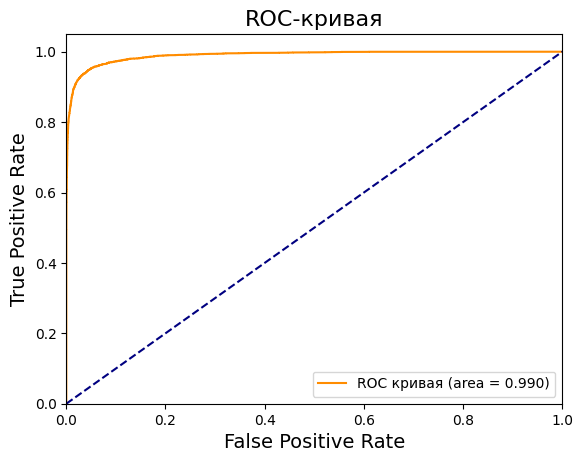

рассчитываем ROC AUC
Epoch 5/5


100%|██████████| 6568/6568 [04:13<00:00, 25.89it/s]


Train loss 0.08269725370122788 accuracy 0.9726638148847788
Valid:
Accuracy: 96.41 %
Recall: 90.17 %
precision: 0.9424382055678869, recall: 0.9401782485849269, f1score: 0.9413029049722164
Test:
Accuracy: 96.64 %
Recall: 91.67 %
precision: 0.9447204646544463, recall: 0.9474618128734553, f1score: 0.9460832305914642
*********************
              precision    recall  f1-score   support

           0     0.9801    0.9782    0.9792     21216
           1     0.9093    0.9167    0.9130      5054

    accuracy                         0.9664     26270
   macro avg     0.9447    0.9475    0.9461     26270
weighted avg     0.9665    0.9664    0.9664     26270

Accuracy: 96.64 %
Recall: 91.67 %
Precision: 90.93 %
F1-score: 91.3 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  20754
False Positives:  462
False Negatives:  421
True Positives:  4633


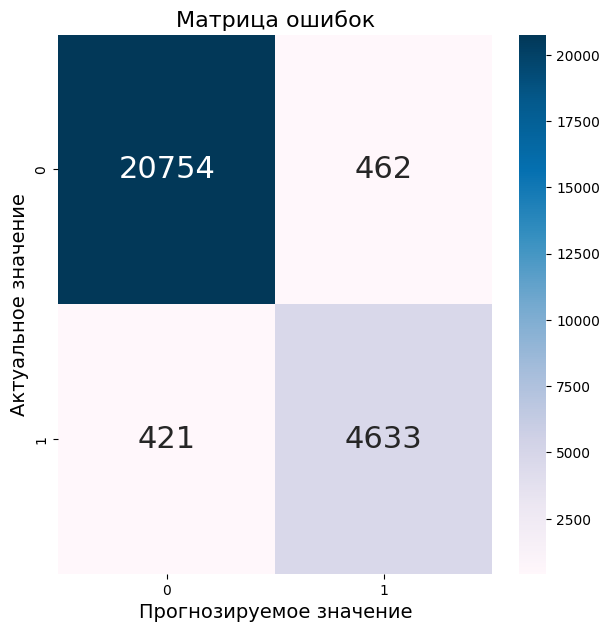

рассчитываем ROC AUC
[0.0056355647, 0.00034595927, 0.00036052646, 0.98782593, 0.00087281404, 0.011314523, 0.0146698095, 0.007476309, 0.00032918283, 0.0050268085, 0.00020834802, 0.000255711, 0.0050430563, 0.0023957915, 0.09887214, 0.0009684109, 0.99833244, 0.00025538745, 0.000280486, 0.00025273187, 0.0026096758, 0.0011271519, 0.0010232043, 0.0049027572, 0.0021749404, 0.00049581233, 0.0003333611, 0.0033997518, 0.010929702, 0.00039099262, 0.005381693, 0.0007419961, 0.00049245433, 0.9945819, 0.0003123763, 0.000575092, 0.00024915056, 0.006095083, 0.0019867455, 0.0016910931, 0.08828331, 0.0017179283, 0.04027619, 0.00063639495, 0.999424, 0.0015352543, 0.00054442545, 0.010889778, 0.0018324659, 0.0020268578, 0.0014439821, 0.003279496, 0.0010684208, 0.0018621429, 0.0033496434, 0.010344679, 0.000547556, 0.0014317989, 0.008085753, 0.0005090398, 0.9854643, 0.0006565089, 0.0014903899, 0.0011043431, 0.002034414, 0.0018007795, 0.0034991945, 0.0009410783, 0.5139393, 0.0018051845, 0.06912505, 0.01982574

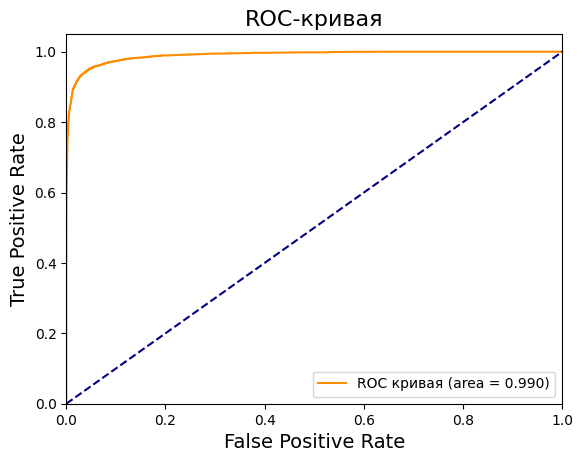

рассчитываем ROC AUC
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

In [9]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny',
    n_classes=2,
    max_len=64
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=  X_val,
        y_valid=  y_val,
        X_test=  X_test,
        y_test=  y_test,
        epochs=5
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)

In [ ]:
antiInterr=777+0